# SOAP NOTE NLP Analysis
1. Form Dataset of the three different Doctor Notes
2. Analyze for ...
    1. Readability (Flesh Reading Ease)
    2. Structure (POS-Ratio, Length)
    3. Emotion (Sentiment Analysis)
    4. Domain (Medical Term Density)
3. Classify the notes based on the features


In [1]:
# Set UP 
!pip install pandas py-readability-metrics textblob scikit-learn seaborn nltk
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

  Using cached pandas-2.3.3-cp313-cp313-macosx_11_0_arm64.whl.metadata (91 kB)
  Using cached py_readability_metrics-1.4.5-py3-none-any.whl.metadata (8.8 kB)
  Using cached textblob-0.19.0-py3-none-any.whl.metadata (4.4 kB)
  Using cached scikit_learn-1.7.2-cp313-cp313-macosx_12_0_arm64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached nltk-3.9.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached numpy-2.3.4-cp313-cp313-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached matplotlib-3.10.7-cp313-cp313-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached click-8.3.0-py3-none-any.whl.metadata (2.6 kB)
  Using cached regex-2025.10.23-cp313-cp313-macosx_11_0_arm64.whl.metadata (

[nltk_data] Downloading package punkt to /Users/alina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/alina/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### #1 Data Preparation
Load all SOAP notes from the specified folder structure and parse them.

In [2]:
import pandas as pd
import os
import re
import glob

# --- Define a helper function to parse the SOAP sections ---
def parse_soap(text):
    """
    Extracts S, O, A, P sections from a SOAP note text using regex.
    Returns a dict with the corresponding fields.
    """
    # This regex is more flexible, allowing for variations in spacing
    pattern = re.compile(
        r"\*\*S:\s*Subjective\*\*(.*?)\*\*O:\s*Objective\*\*(.*?)\*\*A:\s*Assessment\*\*(.*?)\*\*P:\s*Plan\*\*(.*)",
        re.DOTALL | re.IGNORECASE
    )

    match = pattern.search(text)
    if not match:
        print(f"⚠️ Could not parse SOAP sections for a note. Returning empty sections.")
        return {
            "SOAP_Subjective": "",
            "SOAP_Objective": "",
            "SOAP_Assessment": "",
            "SOAP_Plan": ""
        }

    return {
        "SOAP_Subjective": match.group(1).strip(),
        "SOAP_Objective": match.group(2).strip(),
        "SOAP_Assessment": match.group(3).strip(),
        "SOAP_Plan": match.group(4).strip()
    }

# --- Load data from folders ---
base_path = '.' 
groups = ['SOAP_Good', 'SOAP_Bad', 'SOAP_Neutral']
all_notes_data = []

# Check if the group folders exist in the current directory
if not any(os.path.exists(os.path.join(base_path, g)) for g in groups):
    raise FileNotFoundError(f"Could not find SOAP folders (e.g., SOAP_Good) in the current directory. Please check your file structure.")

for group_name in groups:
    folder_path = os.path.join(base_path, group_name)
    # Use glob to find all .txt files
    file_paths = glob.glob(os.path.join(folder_path, '*.txt'))

    if not file_paths:
        print(f"FYI: No .txt files found in {folder_path}")
        continue

    for i, file_path in enumerate(file_paths):
        with open(file_path, "r", encoding="utf-8") as f:
            full_text = f.read()

        parsed_sections = parse_soap(full_text)

        note_data = {
            'ID': f"{group_name.split('_')[1]}_{i+1:03d}",
            'Group': group_name.split('_')[1], # 'Good', 'Bad', 'Neutral'
            'SOAP_Text': full_text.strip(),
            **parsed_sections
        }
        all_notes_data.append(note_data)

# --- Create the master DataFrame ---
df = pd.DataFrame(all_notes_data)

# --- Display result ---
print(f"Successfully loaded {len(df)} notes.")
print("DataFrame Head:")
pd.set_option('display.max_colwidth', 80)
print(df.head())
print("\nGroup Counts:")
print(df['Group'].value_counts())

Successfully loaded 15 notes.
DataFrame Head:
         ID Group  \
0  Good_001  Good   
1  Good_002  Good   
2  Good_003  Good   
3  Good_004  Good   
4  Good_005  Good   

                                                                         SOAP_Text  \
0  "**SOAP Note Report** **S: Subjective** A 62-year-old woman presents with co...   
1  "**SOAP Note Report** **S: Subjective** An 8-month-old boy presented with hi...   
2  "**SOAP Note Report** **S: Subjective** The patient is a 55-year-old male pr...   
3  "**SOAP Note Report** **S: Subjective** A 35-year-old woman presents for a f...   
4  "**SOAP Note Report** **S: Subjective** The patient is a 35-year-old female ...   

                                                                   SOAP_Subjective  \
0  A 62-year-old woman presents with complaints of fatigue, flank pain, and a p...   
1  An 8-month-old boy presented with his mother due to concerns about feeding d...   
2  The patient is a 55-year-old male presenting with

### #2 Analysis: Feature Engineering
Now we define and apply all analysis functions to the DataFrame.

In [3]:
!pip install --upgrade pip readability-metrics

  Using cached readability_metrics-1.0.0-py2.py3-none-any.whl.metadata (3.3 kB)
Using cached readability_metrics-1.0.0-py2.py3-none-any.whl (7.8 kB)


In [ ]:
from readability import Readability
import pandas as pd

def compute_readability(text):
    if not text or not isinstance(text, str) or len(text.split()) < 10:
        return pd.Series({'fk_score': None, 'fk_grade': None})
    r = Readability(text)
    fk = r.flesch_kincaid()
    return pd.Series({
        'fk_score': fk.score,
        'fk_grade': fk.grade_level,
    })

readability_results = df['SOAP_Text'].apply(compute_readability)
readability_results['Group'] = df['Group']


readability_results['fk_score'] = pd.to_numeric(readability_results['fk_score'], errors='coerce')
readability_results['fk_grade'] = pd.to_numeric(readability_results['fk_grade'], errors='coerce')

# --- Group and compute mean ---
group_means = readability_results.groupby('Group')[['fk_score', 'fk_grade']].mean()
group_range = readability_results.groupby('Group')[['fk_score', 'fk_grade']].min(), readability_results.groupby('Group')[['fk_score', 'fk_grade']].max()
print(group_means)
print(group_range)

          fk_score  fk_grade
Group                       
Bad      14.143919      14.0
Good     13.470283      13.6
Neutral  12.422078      12.4
(          fk_score  fk_grade
Group                       
Bad      12.396832        12
Good     12.620045        13
Neutral  11.134800        11,           fk_score  fk_grade
Group                       
Bad      15.657582        16
Good     14.675406        15
Neutral  13.231550        13)


In [ ]:
# --- 2. Structure (Length, POS) and Emotion (Sentiment) ---
def analyze_structure_sentiment(row):
    text = str(row['SOAP_Text'])
    tokens = nltk.word_tokenize(text)

    # Overall Length
    length = len(tokens)

    # Section-wise Length
    len_s = len(nltk.word_tokenize(str(row['SOAP_Subjective'])))
    len_o = len(nltk.word_tokenize(str(row['SOAP_Objective'])))
    len_a = len(nltk.word_tokenize(str(row['SOAP_Assessment'])))
    len_p = len(nltk.word_tokenize(str(row['SOAP_Plan'])))


    # POS Analysis (counts)
    tags = nltk.pos_tag(tokens)
    pos_counts = nltk.FreqDist(tag for word, tag in tags)

    # Sentiment Analysis
    sentiment = TextBlob(text).sentiment.polarity

    # Combine all features into a single Series
    features = {
        'length': length,
        'length_S': len_s,
        'length_O': len_o,
        'length_A': len_a,
        'length_P': len_p,
        'sentiment': sentiment,
        **pos_counts # Unpack the POS counts dictionary
    }
    return pd.Series(features)

structure_sentiment_results = df.apply(analyze_structure_sentiment, axis=1)
structure_sentiment_results['Group'] = df['Group']
grouped = structure_sentiment_results.groupby('Group')[[ 'NN', 'JJ', 'VB', 'RB']]
print(grouped.agg(['sum']))

            NN     JJ    VB    RB
           sum    sum   sum   sum
Group                            
Bad      610.0  324.0  72.0  67.0
Good     627.0  336.0  85.0  39.0
Neutral  588.0  298.0  72.0  31.0


In [13]:
!pip install TextBlob

In [16]:
from textblob import TextBlob

# --- Apply all analysis functions to the DataFrame ---
print("\nStarting feature engineering...")

# --- Create new DataFrames containing the calculated features ---
# This keeps the logic clean and separates calculation from merging.
readability_features = df['SOAP_Text'].apply(compute_readability)
structure_sentiment_features = df.apply(analyze_structure_sentiment, axis=1)

# --- Define lists of known columns for easier management ---
# This prevents accidentally dropping columns if you modify the feature functions.
meta_cols = ['ID', 'Group', 'SOAP_Text', 'SOAP_Subjective', 'SOAP_Objective', 'SOAP_Assessment', 'SOAP_Plan']
# Re-create the base DataFrame to ensure this cell can be re-run safely
base_df = df[meta_cols].copy()

# --- Merge the new features into the base DataFrame using .join() ---
# .join() is safer than pd.concat for this purpose as it avoids creating duplicate columns.
df_features = base_df.join(readability_features)
df_features = df_features.join(structure_sentiment_features)

# --- Data Cleaning and Type Conversion ---
# Convert readability columns to a numeric type.
df_features['fk_score'] = pd.to_numeric(df_features['fk_score'], errors='coerce')
df_features['fk_grade'] = pd.to_numeric(df_features['fk_grade'], errors='coerce')

# Robustly identify the POS tag columns
# These are any columns that are not in our original metadata or the features we just added.
known_non_pos_cols = meta_cols + [
    'fk_score', 'fk_grade', 'length', 'length_S', 'length_O', 'length_A',
    'length_P', 'sentiment', 'medical_density'
]
pos_cols = [col for col in df_features.columns if col not in known_non_pos_cols]

# Fill NaN values
df_features[pos_cols] = df_features[pos_cols].fillna(0)
df_features[['fk_score', 'fk_grade']] = df_features[['fk_score', 'fk_grade']].fillna(df_features[['fk_score', 'fk_grade']].median())

# --- Finalize the DataFrame ---
df = df_features

print("Feature engineering complete.")
print("DataFrame with features:")
print(df.head())

# Verify data types to confirm the fix
print("\nData types of key columns:")
print(df[['fk_score', 'fk_grade', 'sentiment']].dtypes)


Starting feature engineering...
Feature engineering complete.
DataFrame with features:
         ID Group  \
0  Good_001  Good   
1  Good_002  Good   
2  Good_003  Good   
3  Good_004  Good   
4  Good_005  Good   

                                                                         SOAP_Text  \
0  "**SOAP Note Report** **S: Subjective** A 62-year-old woman presents with co...   
1  "**SOAP Note Report** **S: Subjective** An 8-month-old boy presented with hi...   
2  "**SOAP Note Report** **S: Subjective** The patient is a 55-year-old male pr...   
3  "**SOAP Note Report** **S: Subjective** A 35-year-old woman presents for a f...   
4  "**SOAP Note Report** **S: Subjective** The patient is a 35-year-old female ...   

                                                                   SOAP_Subjective  \
0  A 62-year-old woman presents with complaints of fatigue, flank pain, and a p...   
1  An 8-month-old boy presented with his mother due to concerns about feeding d...   
2  The pat

### #3 Visualization
Compare the key features across the different groups.

Generating visualizations...


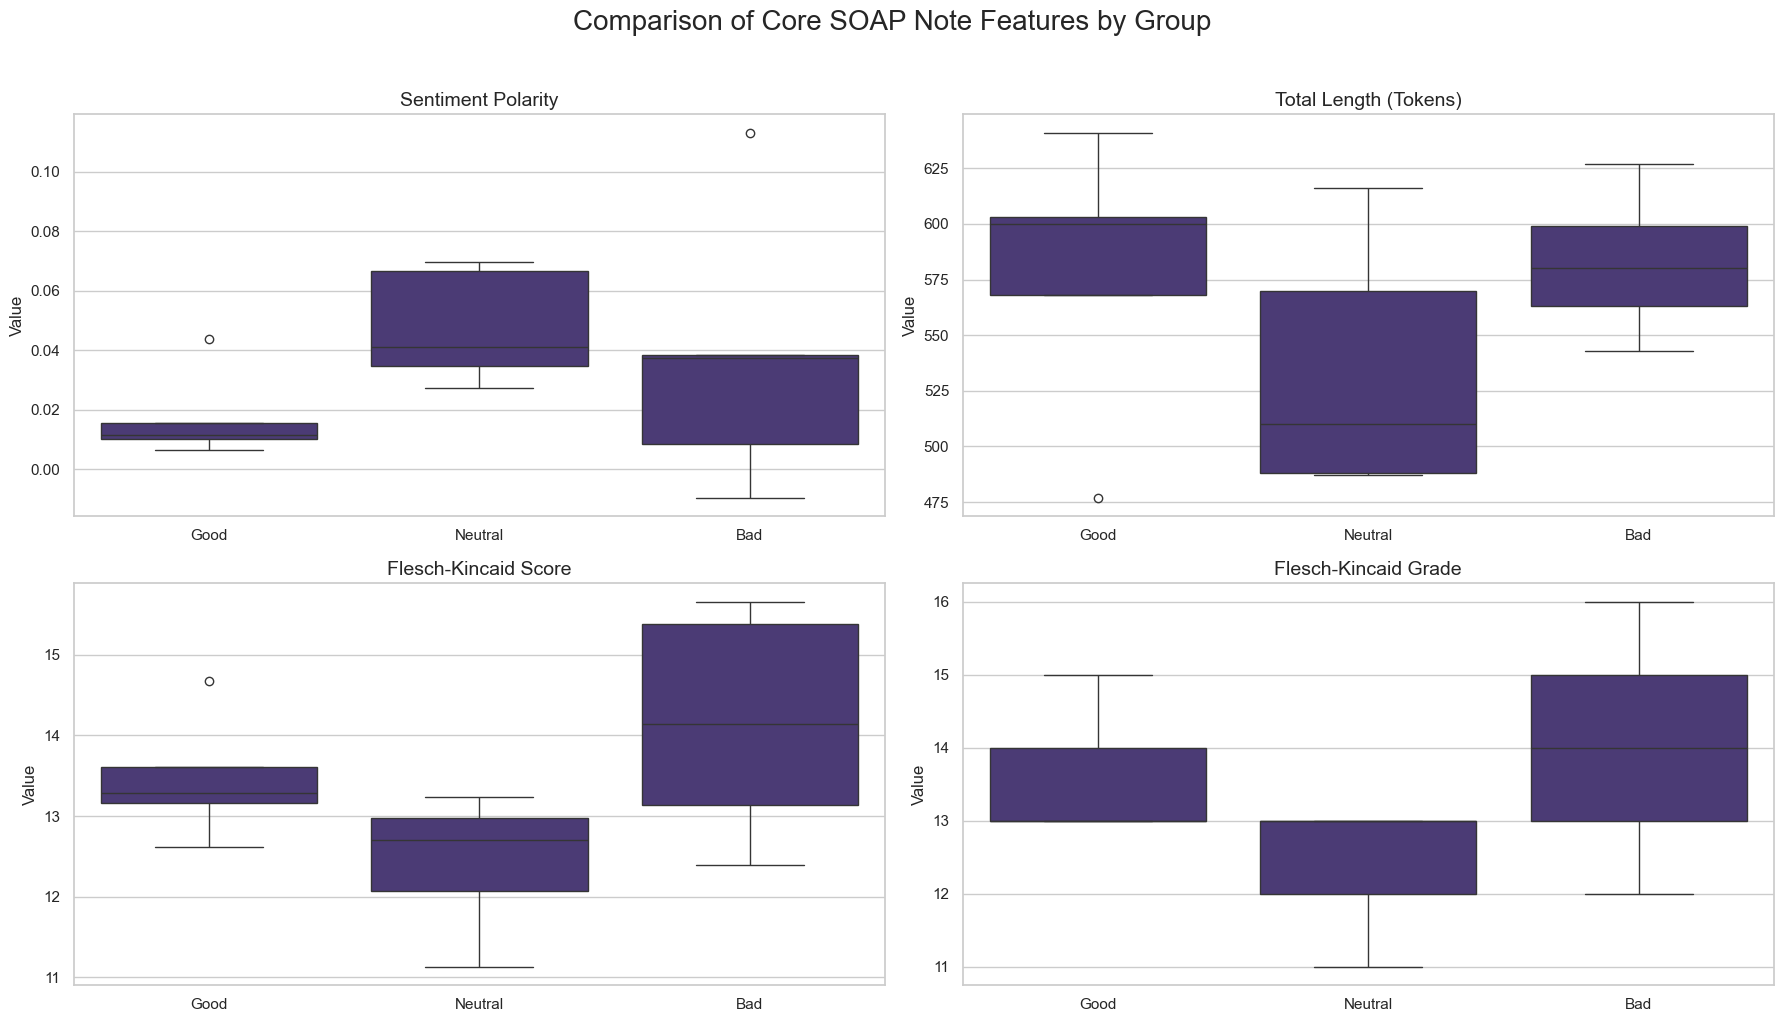

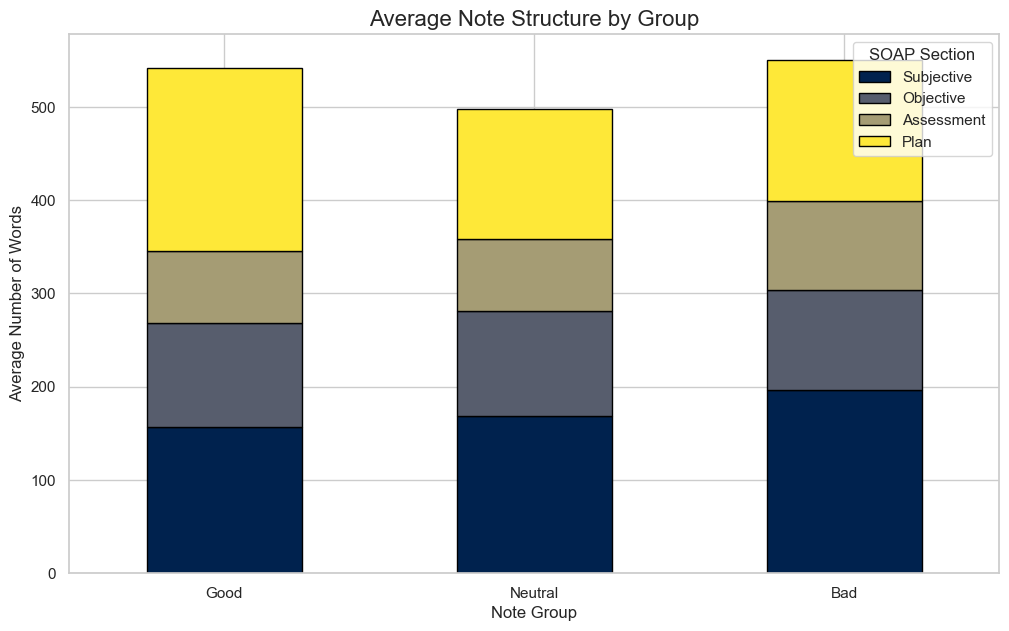

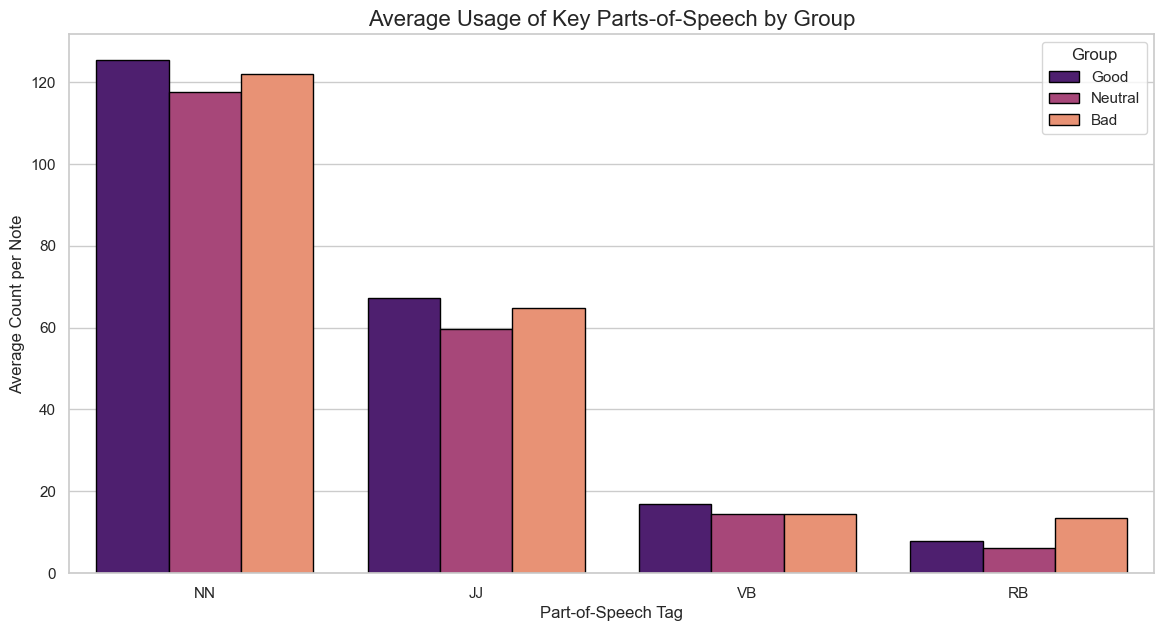

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set a nice, modern theme for all plots
sns.set_theme(style="whitegrid", palette="viridis")
print("Generating visualizations...")

# PLOT 1: Core Metrics Distribution (Boxplots)
features_to_plot = [
    'sentiment', 'length', 'fk_score', 'fk_grade'
]
feature_titles = [
    'Sentiment Polarity', 'Total Length (Tokens)', 'Flesch-Kincaid Score',
    'Flesch-Kincaid Grade'
]

fig, axes = plt.subplots(2, 2, figsize=(18, 10))
fig.suptitle('Comparison of Core SOAP Note Features by Group', fontsize=20, y=1.02)

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, feature in enumerate(features_to_plot):
    # Check if the feature exists (e.g., 'NN' might not appear in very short texts)
    if feature in df.columns:
        sns.boxplot(ax=axes[i], x='Group', y=feature, data=df, order=['Good', 'Neutral', 'Bad'])
        axes[i].set_title(feature_titles[i], fontsize=14)
        axes[i].set_xlabel("")
        axes[i].set_ylabel("Value")
    else:
        axes[i].text(0.5, 0.5, f'Feature "{feature}"\nnot found', ha='center', va='center')
        axes[i].set_title(feature_titles[i], fontsize=14)


plt.tight_layout()
plt.show()

# PLOT 2: Note Structure Analysis (Stacked Bar Chart)
# Calculate the mean length of each section per group
structure_df = df.groupby('Group')[['length_S', 'length_O', 'length_A', 'length_P']].mean()
structure_df = structure_df.reindex(['Good', 'Neutral', 'Bad']) # Ensure consistent order

# Plotting the stacked bar chart
ax = structure_df.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 7),
    cmap='cividis', 
    edgecolor='black'
)

plt.title('Average Note Structure by Group', fontsize=16)
plt.ylabel('Average Number of Words', fontsize=12)
plt.xlabel('Note Group', fontsize=12)
plt.xticks(rotation=0) 
plt.legend(title='SOAP Section', labels=['Subjective', 'Objective', 'Assessment', 'Plan'])
plt.show()



# PLOT 3: Linguistic Style (POS Tag Comparison)
# NN (Noun), JJ (Adjective), VB (Verb), RB (Adverb)
pos_to_compare = [p for p in ['NN', 'JJ', 'VB', 'RB'] if p in df.columns]

if pos_to_compare:
    pos_df = df.groupby('Group')[pos_to_compare].mean().reset_index()

    # Melt the DataFrame to a "long" format suitable for seaborn's barplot
    pos_df_melted = pos_df.melt(
        id_vars='Group',
        var_name='POS_Tag',
        value_name='Average_Count'
    )

    plt.figure(figsize=(14, 7))
    sns.barplot(
        x='POS_Tag',
        y='Average_Count',
        hue='Group',
        data=pos_df_melted,
        hue_order=['Good', 'Neutral', 'Bad'],
        palette='magma',
        edgecolor='black'
    )
    plt.title('Average Usage of Key Parts-of-Speech by Group', fontsize=16)
    plt.xlabel('Part-of-Speech Tag', fontsize=12)
    plt.ylabel('Average Count per Note', fontsize=12)
    plt.show()
else:
    print("Skipping POS tag visualization as key tags (NN, JJ, VB, RB) were not found in the data.")

### #4 Classification
Can a model distinguish the note group (Good, Bad, Neutral) based on the engineered features?


Training Random Forest Classifier...

--- Classification Report ---
              precision    recall  f1-score   support

         Bad       0.33      1.00      0.50         1
        Good       0.50      0.50      0.50         2
     Neutral       0.00      0.00      0.00         2

    accuracy                           0.40         5
   macro avg       0.28      0.50      0.33         5
weighted avg       0.27      0.40      0.30         5

Accuracy: 0.40


/Users/alina/Library/Mobile Documents/com~apple~CloudDocs/Universität/M.Sc. AI for Health/5_RTDS/PsychoAgents/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/alina/Library/Mobile Documents/com~apple~CloudDocs/Universität/M.Sc. AI for Health/5_RTDS/PsychoAgents/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/alina/Library/Mobile Documents/com~apple~CloudDocs/Universität/M.Sc. AI for Health/5_RTDS/PsychoAgents/.venv/lib/python3.13/site-packages/

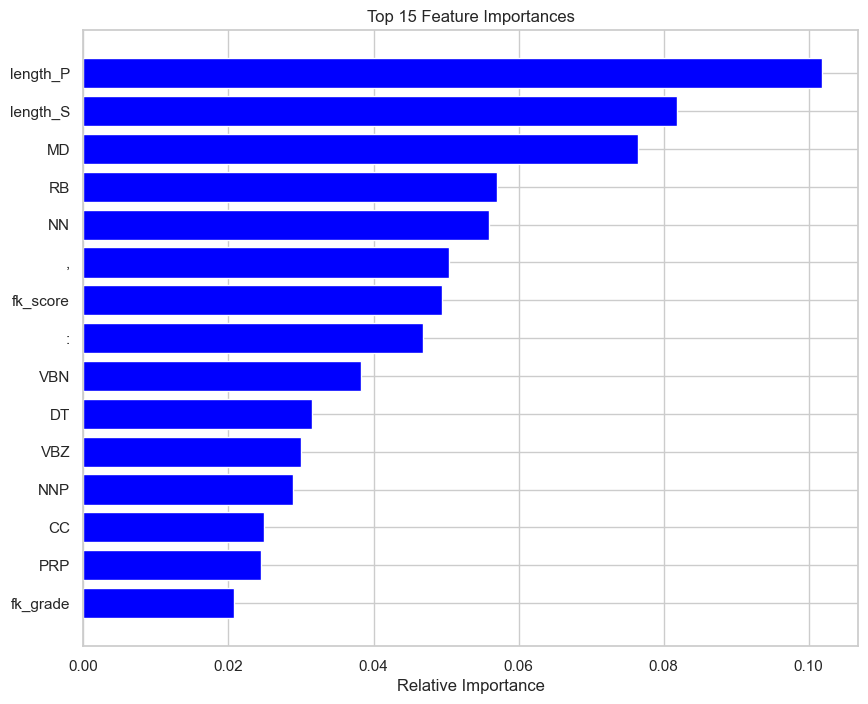

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# --- Feature Selection ---
# Use all the numeric features we created
feature_cols = [
    'fk_score', 'fk_grade', 'length', 'length_S', 'length_O', 'length_A',
    'length_P', 'sentiment', 'medical_density'
] + pos_cols # Add all the POS count columns

# Ensure all feature columns exist in the DataFrame
existing_feature_cols = [col for col in feature_cols if col in df.columns]

X = df[existing_feature_cols]
y = df['Group']

if len(df) < 10 or len(y.unique()) < 2:
    print("\nNot enough data or classes to perform classification. Skipping.")
else:
    # --- Train-Test Split ---
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # --- Model Training ---
    print("\nTraining Random Forest Classifier...")
    clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    clf.fit(X_train, y_train)

    # --- Evaluation ---
    y_pred = clf.predict(X_test)
    print("\n--- Classification Report ---")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

    # --- Feature Importance ---
    importances = clf.feature_importances_
    indices = np.argsort(importances)[-15:] # Top 15 features

    plt.figure(figsize=(10, 8))
    plt.title('Top 15 Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [existing_feature_cols[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()